In [ ]:
import os
import numpy as np
import tempfile
# import caffe
import caffe
caffe.set_mode_gpu()
caffe_root = "/home/gpu_user/corentin/flownet2/"
import sys
flush = sys.stdout.flush

In [3]:
from caffe.proto import caffe_pb2
import tempfile

def create_solver(train_net_path, snapshot_prefix=None, test_net_path=None, base_lr=0.00001):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000  # Test after every 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 500000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'Adam'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'multistep'
    s.gamma = 0.5
    s.stepsize = 20000

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 1e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 50
    s.momentum2 = 0.999

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = snapshot_prefix or '/home/gpu_user/corentin/flownet2/models/random-prefix-%s' % time.time()
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name

In [4]:
import time
def run_solvers(niter, solvers, disp_interval=10, log_file=None, test_interval=20):
    """Run solvers for niter iterations,
   returning the loss and accuracy recorded each iteration.
   `solvers` is a list of (name, solver) tuples."""
    print("Starting training")
    if log_file:
        logs = dict()
        for name, _ in solvers:
            log = open(log_file + '_' + name + '-' + time.strftime('%Y-%m-%d-%H:%M:%S'), 'a')
            logs[name] = log
        
    blobs = ('flow_loss2',)
    loss = [{name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs][0]
    test_loss = [{name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs][0]
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # run a single step in Caffe
            (loss[name][it],) = (s.net.blobs[b].data.copy() for b in blobs)
            ## TEST 
            if it % test_interval == 0 or it == niter - 1:
                correct = 0
                mean_loss = 0
                s.test_nets[0].forward()
                test_loss[name][it] = s.test_nets[0].blobs['flow_loss2'].data
                if log_file:
                    for b in blobs:
                        logs[name].write("%s,%s,%s\n" % (it, str(loss[name][it]), test_loss[name][it])) 
                        logs[name].flush()
            # DONE TESTING
                loss_disp = '; '.join('%s: loss=%.2f, test_loss=%.2f' % (n, loss[n][it],test_loss[n][it]) for n, _ in solvers)
                print '%3d) %s' % (it, loss_disp)
                flush()
                
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        print("saving in %s" % os.path.join(weight_dir, filename))
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
    return loss, test_loss, weights

In [5]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline 

def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    #image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image


In [18]:
caffe_root = "/home/gpu_user/corentin/flownet2/"
model_def = caffe_root + 'models/FlowNet2-s/coco-fine-tune.prototxt'
model_weights = caffe_root + 'models/FlowNet2-s/coco-FlowNet2-s_weights.caffemodel'
assert os.path.exists(model_weights)
assert os.path.exists(model_def)

# Reset solver as before.
solver_filename = create_solver(model_def, test_net_path=model_def)
solver = caffe.get_solver(solver_filename)
solver.net.copy_from(model_weights)

In [20]:
solver.net.forward()
del solver

In [21]:
solver.test_net.forward()
imgs0t = test_net.blobs["blob0"].data.copy()
imgs1t = test_net.blobs["blob1"].data.copy()
flowst = test_net.blobs["blob2"].data.copy()

NameError: name 'solver' is not defined

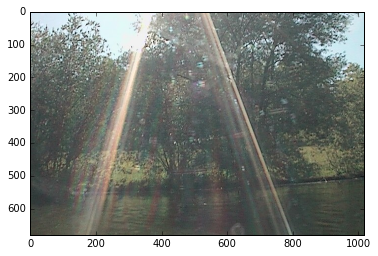

In [30]:
plt.imshow(deprocess_net_image(imgs0t[0]))

Show the images that are in lmdb as blobs

In [77]:
solver.net.forward()
imgs0 = solver.net.blobs["blob0"].data.copy()
imgs1 = solver.net.blobs["blob1"].data.copy()
flows = solver.net.blobs["blob2"].data.copy()

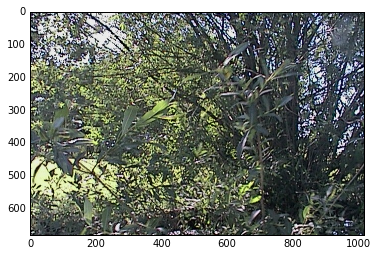

In [81]:
plt.imshow(deprocess_net_image(imgs0[0]))

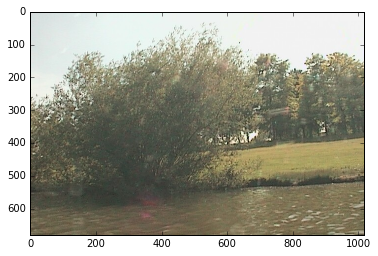

In [52]:
plt.imshow(deprocess_net_image(imgs0[0]))

In [9]:
def disp_preds(net, image, labels, k=5, name='ImageNet'):
    input_blob = net.blobs['data']
    net.blobs['data'].data[0, ...] = image
    probs = net.forward(start='conv1')['probs'][0]
    top_k = (-probs).argsort()[:k]
    print 'top %d predicted %s labels =' % (k, name)
    print '\n'.join('\t(%d) %5.2f%% %s' % (i+1, 100*probs[p], labels[p])
                    for i, p in enumerate(top_k))

def disp_imagenet_preds(net, image):
    disp_preds(net, image, imagenet_labels, name='ImageNet')

def disp_style_preds(net, image):
    disp_preds(net, image, style_labels, name='style')

In [21]:
niter = 1000  # number of iterations to train

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained', solver)]
loss, weights = run_solvers(niter, solvers)
print 'Done.'

train_loss = loss['pretrained']
weights = weights['pretrained']
# Delete solvers to save memory (no)

Running solvers for 1000 iterations...
  0) pretrained: loss=72277.492
 10) pretrained: loss=65641.258
 20) pretrained: loss=73247.852
 30) pretrained: loss=71794.062
 40) pretrained: loss=75782.422
 50) pretrained: loss=76310.672
 60) pretrained: loss=67999.773
 70) pretrained: loss=74307.906
 80) pretrained: loss=69258.148
 90) pretrained: loss=69616.289
100) pretrained: loss=70775.758
110) pretrained: loss=66132.477
120) pretrained: loss=63887.086
130) pretrained: loss=65879.766
140) pretrained: loss=68466.484
150) pretrained: loss=72203.094
160) pretrained: loss=68028.164
170) pretrained: loss=67651.312
180) pretrained: loss=67763.422
190) pretrained: loss=71509.234
200) pretrained: loss=69982.922
210) pretrained: loss=72472.500
220) pretrained: loss=72210.180
230) pretrained: loss=63505.742
240) pretrained: loss=67527.531
250) pretrained: loss=66961.844
260) pretrained: loss=67124.875
270) pretrained: loss=69958.609
280) pretrained: loss=68988.031
290) pretrained: loss=65506.141
3

#### Function to train the network, giving 

- prototxt path
- initial weights path
- output weights path
- number of iterations

In [6]:
def train(prototxt, initial_weights, output_weights, iterations, 
         solver=None, disp_interval=10, log_file=None):
    print "Loading net and solver"
    if solver is None:
        solver_filename = create_solver(prototxt, snapshot_prefix=output_weights, test_net_path=prototxt)
        solver = caffe.get_solver(solver_filename)
        solver.net.copy_from(initial_weights)
    solvers = [('solver', solver)]
    loss, test_loss, weights = run_solvers(iterations, solvers, disp_interval=disp_interval, log_file=log_file)
    print('Done.')
    train_loss = loss['solver']
    #weights = weights['pretrained']
    solver.net.save(output_weights)
    print("Weights saved in %s" % output_weights)
    return solver, train_loss, test_loss


In [7]:
def eval_net(prototxt, weights, test_iters=10):
    test_net = caffe.Net(prototxt, weights, caffe.TEST)
    loss = 0
    for it in xrange(test_iters):
        loss += test_net.forward()['flow_loss2']
    loss /= test_iters
    return test_net, loss

import sys
sys.path.append("OpticalFlowToolkit/")
from lib.flowlib import read_flow, show_flow 

In [8]:
from run_model import run_model

## MODEL 200,000 iterations, fine-tune last layer

In [9]:
prototxt = caffe_root + "/models/FlowNet2-s/coco-fine-tune.prototxt"
previous_weights = caffe_root + '/models/FlowNet2-s/coco-FlowNet2-s_weights.caffemodel'
output_weights =  caffe_root + "/models/FlowNet2-s/coco-weights-3.caffemodel"

In [25]:
_, loss, test_loss = train(prototxt, previous_weights, caffe_root + "/models/FlowNet2-s/coco-weights-4.caffemodel", 
                           iterations=100000, disp_interval=20,
                          log_file=caffe_root + "/models/FlowNet2-s/train-logs")

Loading net and solver
Starting training


KeyboardInterrupt: 

In [ ]:
eval_net(prototxt, output_weights, test_iters=10)

### Test on an image

In [20]:
deploy_model = "/home/gpu_user/corentin/flownet2/models/FlowNet2-s/FlowNet2-s_deploy.prototxt.template"
img0 = "/home/gpu_user/corentin/testing_set/0010-1.ppm"
img1 = "/home/gpu_user/corentin/testing_set/0010-2.ppm"
real_flow = "/home/gpu_user/corentin/testing_set/0010.flo"
estimated_flow_ft = "/home/gpu_user/corentin/testing_set/0010-estimated.flo"
estimated_flow_ori = "/home/gpu_user/corentin/testing_set/0010-estimated-ori.flo"

run_model(deploy_model, output_weights, img0, img1, estimated_flow_ft)
run_model(deploy_model, previous_weights, img0, img1, estimated_flow_ori)

Network forward pass using /home/gpu_user/corentin/flownet2/models/FlowNet2-s/coco-weights-3.caffemodel.
Succeeded.
Network forward pass using /home/gpu_user/corentin/flownet2/models/FlowNet2-s/coco-FlowNet2-s_weights.caffemodel.
Succeeded.


Reading 680 x 1016 flow file in .flo format
max flow: 26.4416
flow range:
u = -26.014 .. 9.402
v = -8.538 .. 11.009


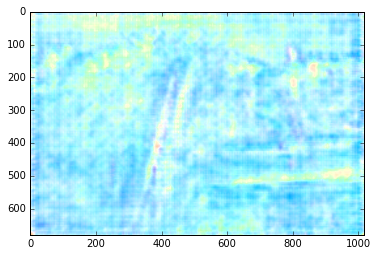

Reading 680 x 1016 flow file in .flo format
max flow: 64.8573
flow range:
u = 29.394 .. 50.302
v = 29.655 .. 47.504


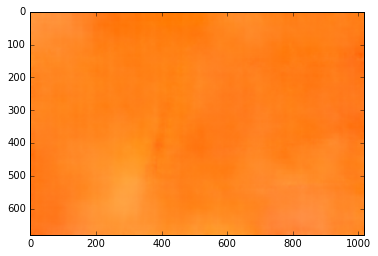

In [25]:
show_flow(estimated_flow_ft)
show_flow(estimated_flow_ori)

In [ ]:
from tools import 

 ## TEST on 100,000 iterations with all layers

In [10]:
prototxt = caffe_root + "/models/FlowNet2-s/coco-fine-tune-all-layers.prototxt"
previous_weights = caffe_root + '/models/FlowNet2-s/coco-FlowNet2-s_weights.caffemodel'
output_weights =  caffe_root + "/models/FlowNet2-s/coco-weights-full-train.caffemodel"

In [ ]:
_, loss, test_loss = train(prototxt, previous_weights, caffe_root + "/models/FlowNet2-s/coco-weights-full-train.caffemodel", 
                           iterations=100000, disp_interval=20,
                          log_file=caffe_root + "/models/FlowNet2-s/full-train-logs")

Loading net and solver
Starting training
  0) solver: loss=68555.95, test_loss=50671.85
 20) solver: loss=43106.33, test_loss=41632.33
 40) solver: loss=35203.55, test_loss=33921.48
